<a href="https://colab.research.google.com/github/neilalden/audio_classification/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa
!pip install pydub

In [ ]:
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import numpy as np
import pydub
from scipy.io import wavfile as wav
from tqdm import tqdm
import os
from google.colab import drive
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from datetime import datetime 
import tensorflow.keras as keras
from sklearn.preprocessing import LabelEncoder


%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')
archive_dir = '/content/drive/MyDrive/Speech Recognition/archive'
recording_dir = archive_dir+"/recordings/recordings"
!dir

Mounted at /content/drive
drive  sample_data


In [ ]:
metadata = pd.read_csv(archive_dir+'/speakers_all.csv')
metadata = metadata.dropna(axis=1, how='any')

In [ ]:
metadata = metadata.loc[metadata['native_language'] == "english"]
metadata

,age,age_onset,filename,native_language,sex,speakerid,file_missing?
363,42.0,0.0,english1,english,male,61,False
364,35.0,0.0,english10,english,female,62,False
365,23.0,0.0,english100,english,female,63,False
366,18.0,0.0,english101,english,female,64,False
367,22.0,0.0,english102,english,male,65,False
...,...,...,...,...,...,...,...
937,18.0,0.0,english95,english,male,160,False
938,31.0,0.0,english96,english,male,161,False
939,42.0,0.0,english97,english,male,162,False
940,22.0,0.0,english98,english,male,163,False


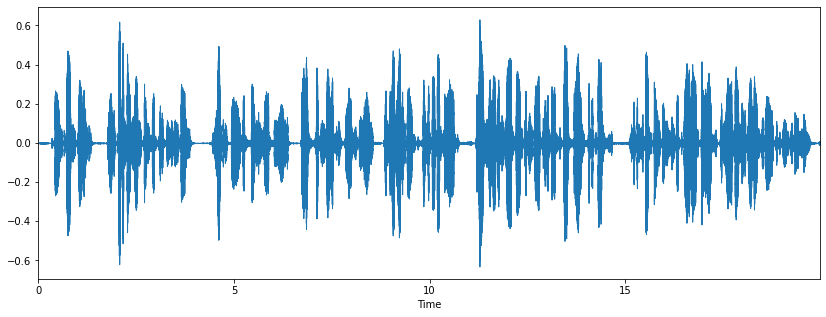

In [ ]:
filename = recording_dir+"/english101.mp3"
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

In [ ]:
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return  y,a.frame_rate

In [ ]:
def features_extractor(file):
    audio, sample_rate  = read(recording_dir+file+".mp3")
    audio = np.float_(audio)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [ ]:
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(recording_dir),'/',str(row["filename"]))
    data=features_extractor(file_name)
    final_class_labels=row["sex"]

    extracted_features.append([data,final_class_labels])
    

579it [05:54,  1.63it/s]


In [ ]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df["class"].value_counts()

male      309
female    270
Name: class, dtype: int64

In [ ]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
labelencoder=LabelEncoder()
y=(labelencoder.fit_transform(y))

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25, random_state = 0)

In [ ]:
n_input = 40
n_features = 1

In [ ]:
X_train[0]

array([ 6.97717937e+02,  9.81750124e+01, -5.18629765e+01,  5.24051014e+01,
        1.99232314e+01,  1.62899855e+01, -2.97786383e+00,  1.45133068e+00,
        7.46366653e-01,  9.88812808e+00, -1.24680341e+00,  1.32310542e+01,
       -6.75817660e+00,  5.09398085e-01,  4.87955934e+00, -1.30081408e+00,
        1.67277983e+00,  3.00596871e+00,  3.58281053e+00,  2.37090980e+00,
       -3.60562315e-01,  4.33152884e+00,  2.73097533e+00,  2.85470942e-01,
        3.80610293e+00, -1.04245164e+00,  2.25770437e+00, -2.06465276e-01,
       -1.53459632e+00,  1.26002450e+00,  8.03568726e-01, -2.12792745e-01,
       -2.66998680e-01,  7.58748300e-01, -5.66823582e-01,  8.89651159e-02,
       -1.95317956e+00,  3.19250521e-02,  1.63920981e+00, -1.12837119e+00])

In [ ]:
X_train = np.array([x.reshape( (8, 5, 1) ) for x in X_train])
X_test = np.array([x.reshape( (8, 5, 1) ) for x in X_test])

In [ ]:
X_train[0]

array([[[ 6.97717937e+02],
        [ 9.81750124e+01],
        [-5.18629765e+01],
        [ 5.24051014e+01],
        [ 1.99232314e+01]],

       [[ 1.62899855e+01],
        [-2.97786383e+00],
        [ 1.45133068e+00],
        [ 7.46366653e-01],
        [ 9.88812808e+00]],

       [[-1.24680341e+00],
        [ 1.32310542e+01],
        [-6.75817660e+00],
        [ 5.09398085e-01],
        [ 4.87955934e+00]],

       [[-1.30081408e+00],
        [ 1.67277983e+00],
        [ 3.00596871e+00],
        [ 3.58281053e+00],
        [ 2.37090980e+00]],

       [[-3.60562315e-01],
        [ 4.33152884e+00],
        [ 2.73097533e+00],
        [ 2.85470942e-01],
        [ 3.80610293e+00]],

       [[-1.04245164e+00],
        [ 2.25770437e+00],
        [-2.06465276e-01],
        [-1.53459632e+00],
        [ 1.26002450e+00]],

       [[ 8.03568726e-01],
        [-2.12792745e-01],
        [-2.66998680e-01],
        [ 7.58748300e-01],
        [-5.66823582e-01]],

       [[ 8.89651159e-02],
        [-1.95

In [ ]:
model = Sequential()

model.add(Conv2D(20, (2, 2), strides=(1, 1), input_shape=(8, 5, 1)))
model.add(MaxPooling2D((4,4), strides=(4,4), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(40, (1, 1), padding="valid"))
model.add(MaxPooling2D((1, 1), strides=(1, 1)))
model.add(Activation('relu'))


model.add(Conv2D(40, (1, 1), padding="valid"))
model.add(Activation('relu'))


###second layer
model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

###third layer
model.add(Dense(n_features))
model.add(Activation('sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 7, 4, 20)          100       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 2, 1, 20)         0         
 g2D)                                                            
                                                                 
 activation_63 (Activation)  (None, 2, 1, 20)          0         
                                                                 
 conv2d_96 (Conv2D)          (None, 2, 1, 40)          840       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 2, 1, 40)         0         
 g2D)                                                            
                                                                 
 activation_64 (Activation)  (None, 2, 1, 40)        

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/cnn_audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
 9/14 [==================>...........] - ETA: 0s - loss: 7.0981 - accuracy: 0.4792  
Epoch 1: val_loss improved from inf to 1.17561, saving model to saved_models/audio_classification.hdf5
14/14 [==============================] - 1s 25ms/step - loss: 5.8905 - accuracy: 0.4816 - val_loss: 1.1756 - val_accuracy: 0.4759
Epoch 2/100
10/14 [====================>.........] - ETA: 0s - loss: 2.5041 - accuracy: 0.5406
Epoch 2: val_loss improved from 1.17561 to 1.01680, saving model to saved_models/audio_classification.hdf5
14/14 [==============================] - 0s 11ms/step - loss: 2.5261 - accuracy: 0.5253 - val_loss: 1.0168 - val_accuracy: 0.4759
Epoch 3/100
 9/14 [==================>...........] - ETA: 0s - loss: 1.6626 - accuracy: 0.5243
Epoch 3: val_loss improved from 1.01680 to 0.68092, saving model to saved_models/audio_classification.hdf5
14/14 [==============================] - 0s 11ms/step - loss: 1.5304 - accuracy: 0.5300 - val_loss: 0.6809 - val_accuracy: 0.4828
Epoch 

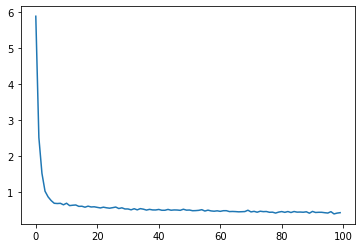

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8275862336158752


In [ ]:
filename="/english100"
mfccs_scaled_features = features_extractor(filename)
mfccs_scaled_features = mfccs_scaled_features.reshape((-1,8, 5, 1))


predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform([int(round(predicted_label[0][0],2))]) 
prediction_class

[[7.2105564e-07]]


array(['female'], dtype='<U6')

In [ ]:
metadata

,age,age_onset,filename,native_language,sex,speakerid,file_missing?
363,42.0,0.0,english1,english,male,61,False
364,35.0,0.0,english10,english,female,62,False
365,23.0,0.0,english100,english,female,63,False
366,18.0,0.0,english101,english,female,64,False
367,22.0,0.0,english102,english,male,65,False
...,...,...,...,...,...,...,...
937,18.0,0.0,english95,english,male,160,False
938,31.0,0.0,english96,english,male,161,False
939,42.0,0.0,english97,english,male,162,False
940,22.0,0.0,english98,english,male,163,False
